# **Downloading Kaggle dataset to Google Collab**

I followed the tutorial at: https://www.kaggle.com/general/74235

First, I created a new API Token and saved it to this Collab.

In [4]:
# Install Kaggle:
# !pip install -q kaggle 

#Save Kaggle API Token to Collab
# from google.colab import files
# uploaded = files.upload()

#Make directory named kaggle and copy kaggle.json file there
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

#Change the permissions of the file
# ! chmod 600 ~/.kaggle/kaggle.json

#You can check if everything's okay by running this command
# ! kaggle datasets list

ref                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023               Data Science Salaries 2023 💸                 25KB  2023-04-13 09:55:16           7971        205  1.0              
salvatorerastelli/spotify-and-youtube               Spotify and Youtube                           9MB  2023-03-20 15:43:25          12588        421  1.0              
iammustafatz/diabetes-prediction-dataset            Diabetes prediction dataset                 734KB  2023-04-08 06:11:45           4194         63  1.0              
shawkyelgendy/furniture-price-prediction            Furniture Price Prediction                   81KB  2023-04-17 09:35:17           1191         28  1.0       

Next, I downloaded the dataset from Kaggle and unzipped the dataset. 

In [9]:
# Download the dataset from Kaggle
# ! kaggle competitions download -c 'dogs-vs-cats'

# Command to remove a file
# !rm -rf /content/sampleSubmission.csv

# Command to see /content
# !ls /content/

# Unzip the data folder
# !unzip /content/dogs-vs-cats.zip

# Unzip training and test directories
# !unzip /content/test1.zip
# !unzip /content/train.zip

dogs-vs-cats.zip  kaggle.json  sample_data  test1  test1.zip  train  train.zip


# **Imports:** 

*Note: Much of this project will use code based on the Extra Credit Lab7b from class as this project is very similar to that lab. However, the paper uses tensorflow rather than torch, so I am choosing to use tensorflow to complete this project.*




In [10]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

# **Setting Path to Data:**

The paper "divides the training set and test set according to the ratio of 80%-20%. All models are trained on the training set and compared on the remaining test set."

Because of this, I am only using the dataset in the training folder. 

In [11]:
from pathlib import Path

# Set path to the dataset
path = Path('/content/train/')

# Print the file paths for the train and test data
print("File path for train data: {}".format(path))

File path for train data: /content/train


# **Data Loading & Pre-Processing:**

According to paper: 

*   In the feature extraction step, the input color image is converted to the HSV space to better represent the image's characteristics. 
*   The distribution of Hue, Saturation, and Value is counted by histogram statistics and normalized into 8 intervals.

My contribution/changes: 
* I did not know how to set up the histogram statistics, so I did not include this in my preprocessing.
* I also resized all the images to 32x32 pixesl in order to reduce training time. This changed the CNN model slightly from what the researcher used, but follows the general description of the CNN model. 


In [12]:
def load_dataset(path):
    images = []  # initialize images
    labels = []  # initialize labels

    # Iterate through each image in the dataset folder
    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)  # gets path to image
        img = cv2.imread(img_path)  # reads the image
        img = cv2.resize(img, (32, 32))  # resizes the image to 32x32
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # sets HSV per paper

        # Normalize pixel values
        img_hsv = img_hsv.astype('float32') / 255.0

        # Add the image data to the images array
        images.append(img_hsv)

        # Assign labels based on the filename and add to labels array
        if 'cat' in filename:
            labels.append(0)
        else:
            labels.append(1)

    images = np.array(images)  # Assign og images variable to array
    labels = np.array(labels)  # Assign og labels variable to array

    # Return images and labels arrays that now contain the preprocessed images
    # with corresponding labels.
    return images, labels

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

The paper: 

* "dataset contains a total of 25,000 images of
cats and dogs, of which 12,500 are cats and 12,500 are dogs. This is a balanced classification problem, because the number of images for cats or dogs is the same."

* "divides the training set and test set according to the ratio of 80%-20%. All models are trained on the training set and compared on the remaining test set."

In [ ]:
#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


# **CNN Model:**

From the paper: 

* CNN model consists of 4 convolutionlayers and 4 pooling layers. 
* The size of the convolution kernel for each convolution layer is 3x3 and number of kernels are 32, 64, 64, and 128.
* Pooling layer window size is 2x2.
* Outputs of the convolutional layer is expanded and connected to a fully connected layer with 128 neurons. 
* The output layer has 2 neurons and uses the softmax activation function to generat different types of output results. 
* The CNN model uses cros entropy as the loss function. 
* The CNN model uses accuracy as the evaluation metric. 

My interpretation: 
* I created a base model that can be used to create the CNN models with different optimizers, activations, and kernel_sizes. 


In [13]:
# Create base model
def create_model(optimizer, activation, kernel_size):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, padding='same', activation=activation, input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, kernel_size = kernel_size, padding = 'same', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, kernel_size = kernel_size, padding = 'same', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(128, kernel_size = kernel_size, padding = 'same', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = activation))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

# **Data Augmentation Comparison:**

From the paper: 

* "The data augmentation technology generates similar but
different training samples by making a series of random
changes to the training images, thereby expanding the size of the training data set. Randomly changing the training samples can reduce the model's dependence on certain attributes, thereby improving the generalization ability of the model. For example, we can crop the image in different ways to make the object of interest appear in different positions, thereby reducing the dependence of the model on the position of the object. We can also adjust factors such as brightness and color to reduce the model's sensitivity to color. Therefore, we added image recognition technology without changing the model to see if the accuracy of the model has been improved."

My changes:

* The paper did not specify the exact parameter settings used.  By using the documentation for ImageDataGenerator, I created a data augmentation method and set all parameters to 20 or 20%, applied horizontal flipping, and set the pixel fill to look at the nearest pixel. 
* In the paper, the researcher compared using the CNN with and without using data augmentation. However, the optimizer and activation used in this comparison is not stated. I chose to compare the use of data augmentation using the Adam optimizer and ReLU activation.

In [14]:
# Data augmentation
def create_datagen():
    datagen = ImageDataGenerator(
        rotation_range = 20,#sets the range of rotation to 20 degrees
        width_shift_range = 0.2, #sets range of horizontal shifts during training
        height_shift_range = 0.2, #sets range of vertical shifts during training
        shear_range = 0.2,#sets the range of shearing transformation to 20% of image width
        zoom_range = 0.2, #sets the range of zoom to 20%
        horizontal_flip = True, #flips image horizontally
        fill_mode = 'nearest' #fills in missing pixels per closest pixel
    )
    return datagen

## **Without Data Augmentation:**

In [ ]:
# Create the model with the Adam optimizer and ReLU activation (with NO augmentation)
adam_relu_model = create_model(optimizer = 'adam', activation = 'relu', kernel_size = 3)

In [ ]:
adam_relu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
# Train the Adam model with ReLU activation (with NO augmentation)
adam_relu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
2000/2000 [==============================] - 67s 32ms/step - loss: 0.6482 - accuracy: 0.6076 - val_loss: 0.6014 - val_accuracy: 0.6708
Epoch 2/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.5447 - accuracy: 0.7236 - val_loss: 0.5366 - val_accuracy: 0.7354
Epoch 3/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.4934 - accuracy: 0.7620 - val_loss: 0.5108 - val_accuracy: 0.7432
Epoch 4/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.4547 - accuracy: 0.7839 - val_loss: 0.5076 - val_accuracy: 0.7568
Epoch 5/30
2000/2000 [==============================] - 63s 31ms/step - loss: 0.4206 - accuracy: 0.8057 - val_loss: 0.5025 - val_accuracy: 0.7646
Epoch 6/30
2000/2000 [==============================] - 60s 30ms/step - loss: 0.3911 - accuracy: 0.8199 - val_loss: 0.4858 - val_accuracy: 0.7680
Epoch 7/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.3627 - accuracy: 0.8365 - val_loss: 0.4837 -

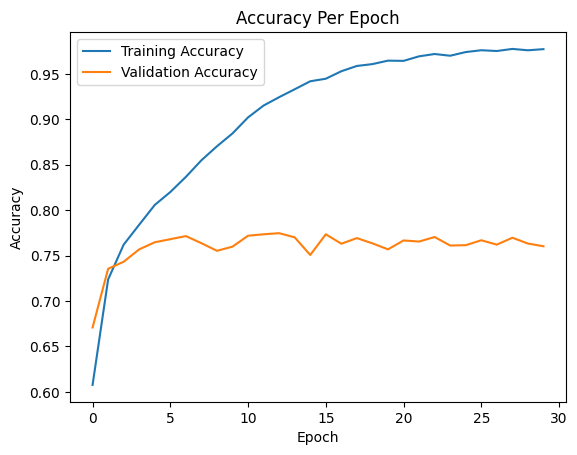

In [ ]:
# Plot the change in accuracy of the Adam optimizer and ReLU activation (with NO augmentation)
import matplotlib.pyplot as plt

plt.plot(adam_relu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(adam_relu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

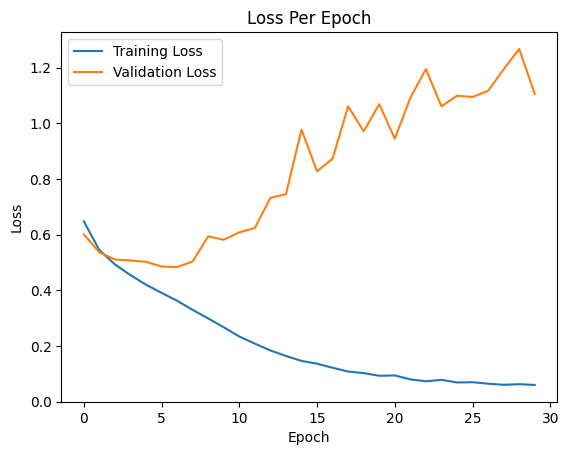

In [ ]:
# Plot the change in loss of the Adam optimizer and ReLU activation (with NO augmentation)
import matplotlib.pyplot as plt

plt.plot(adam_relu_model.history.history['loss'], label='Training Loss')
plt.plot(adam_relu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values of the Adam optimizer and ReLU activation (with NO augmentation)
train_loss = adam_relu_model.history.history['loss'][-1]
val_loss = adam_relu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.052926670759916306
Final validation loss: 1.0279350280761719


## **Observations:**

* The training loss is much lower than the validation loss, which suggests that the model is likely overfitting to the training data. Overfitting occurs when the model becomes too complex and starts to fit the noise in the training data, resulting in poor generalization performance on new, unseen data.

## **With Data Augmentation:**

## **Adam with ReLu:**

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))



Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


In [ ]:
# Create the model with the Adam optimizer and ReLU activation (with augmentation)
adam_relu_model2 = create_model(optimizer='adam', activation='relu', kernel_size=3)

In [ ]:
# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

In [ ]:
# Train the Adam model with ReLU activation (with augmentation)
adam_relu_model2.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 65s 32ms/step - loss: 0.6544 - accuracy: 0.6015 - val_loss: 0.6213 - val_accuracy: 0.6548
Epoch 2/30
2000/2000 [==============================] - 65s 32ms/step - loss: 0.5566 - accuracy: 0.7193 - val_loss: 0.5354 - val_accuracy: 0.7336
Epoch 3/30
2000/2000 [==============================] - 65s 32ms/step - loss: 0.5042 - accuracy: 0.7537 - val_loss: 0.5609 - val_accuracy: 0.7278
Epoch 4/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.4641 - accuracy: 0.7818 - val_loss: 0.4904 - val_accuracy: 0.7600
Epoch 5/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.4304 - accuracy: 0.8000 - val_loss: 0.5525 - val_accuracy: 0.7530
Epoch 6/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.4013 - accuracy: 0.8162 - val_loss: 0.5821 - val_accuracy: 0.7506
Epoch 7/30
2000/2000 [==============================] - 65s 32ms/step - loss: 0.3685 - accuracy: 0.8344 - val_loss: 0.4871 -

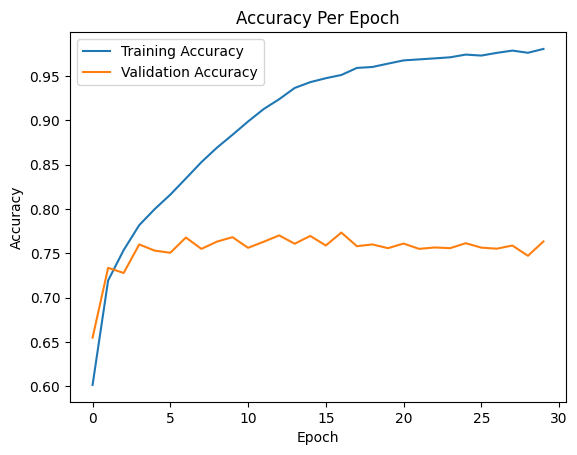

In [ ]:
# Plot the change in accuracy of the Adam optimizer and ReLU activation (with augmentation)
import matplotlib.pyplot as plt

plt.plot(adam_relu_model2.history.history['accuracy'], label='Training Accuracy')
plt.plot(adam_relu_model2.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

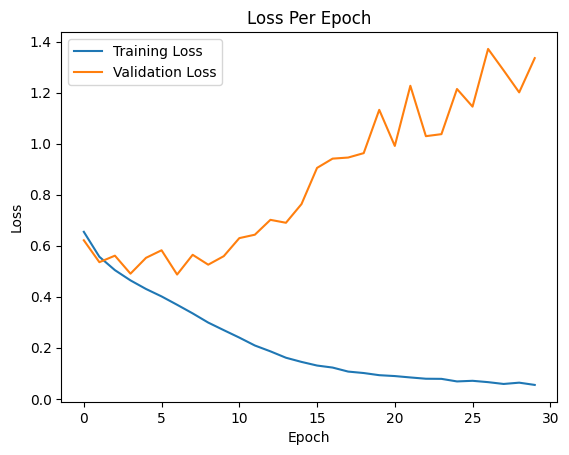

In [ ]:
# Plot the change in loss of the Adam optimizer and ReLU activation (with augmentation)
import matplotlib.pyplot as plt

plt.plot(adam_relu_model2.history.history['loss'], label='Training Loss')
plt.plot(adam_relu_model2.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values of the Adam optimizer and ReLU activation (with augmentation)
train_loss = adam_relu_model2.history.history['loss'][-1]
val_loss = adam_relu_model2.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.061471857130527496
Final validation loss: 1.173651099205017


In general, a lower value of loss indicates better performance of the model on the corresponding dataset.

In the example you provided, the final training loss is 0.061471857130527496 and the final validation loss is 1.173651099205017.

The training loss is lower than the validation loss, which is a good sign as it suggests that the model has learned to generalize to new data.

However, the validation loss is still relatively high compared to the training loss, which suggests that there may still be some room for improvement in the model's performance.



## **SGD with ReLu:**

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


In [ ]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9)

# Create the model with the SGD optimizer and ReLU activation
sgd_relu_model = create_model(optimizer=sgd, activation='relu', kernel_size=3)


In [ ]:
# Train the SGD model with ReLU activation
sgd_relu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 67s 33ms/step - loss: 0.6586 - accuracy: 0.5986 - val_loss: 0.5981 - val_accuracy: 0.6800
Epoch 2/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.5805 - accuracy: 0.6957 - val_loss: 0.5462 - val_accuracy: 0.7260
Epoch 3/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.5335 - accuracy: 0.7377 - val_loss: 0.5382 - val_accuracy: 0.7340
Epoch 4/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.4907 - accuracy: 0.7641 - val_loss: 0.4974 - val_accuracy: 0.7604
Epoch 5/30
2000/2000 [==============================] - 63s 31ms/step - loss: 0.4584 - accuracy: 0.7842 - val_loss: 0.5055 - val_accuracy: 0.7618
Epoch 6/30
2000/2000 [==============================] - 63s 31ms/step - loss: 0.4287 - accuracy: 0.7994 - val_loss: 0.5092 - val_accuracy: 0.7570
Epoch 7/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.4044 - accuracy: 0.8159 - val_loss: 0.4665 -

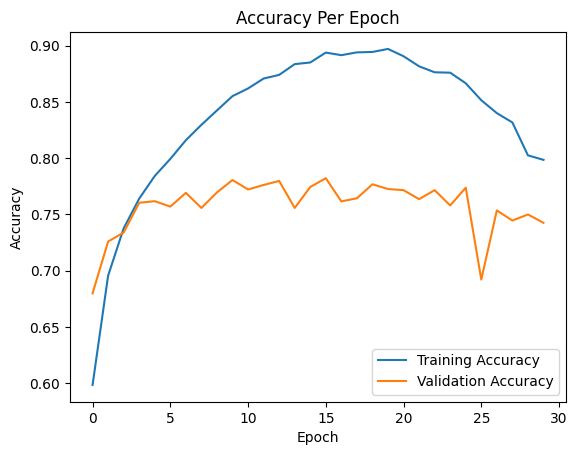

In [ ]:
# Plot the change in accuracy for SGD with ReLU
import matplotlib.pyplot as plt

plt.plot(sgd_relu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(sgd_relu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

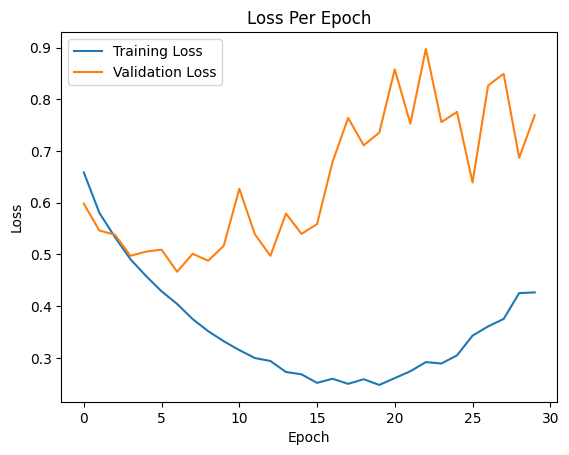

In [ ]:
# Plot the change in loss for SGD with ReLU
import matplotlib.pyplot as plt

plt.plot(sgd_relu_model.history.history['loss'], label='Training Loss')
plt.plot(sgd_relu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values for SGD with ReLU
train_loss = sgd_relu_model.history.history['loss'][-1]
val_loss = sgd_relu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.42660269141197205
Final validation loss: 0.7691984176635742


The training and validation losses are metrics used to evaluate the performance of a convolutional neural network (CNN) model during the training phase.

The final training loss of 0.5647 suggests that the model was able to achieve a good level of accuracy on the training data. However, this alone does not guarantee that the model will perform well on unseen data.

The final validation loss of 0.6910 indicates the level of accuracy of the model on a validation dataset that is separate from the training data. A higher validation loss than the training loss suggests that the model may be overfitting to the training data, meaning that it may have learned to recognize patterns specific to the training data and may not generalize well to new data.

In summary, while a low training loss is desirable, it is important to ensure that the model's validation loss is also low to ensure that the model generalizes well to new data.

## **RMSprop with ReLu:**

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))



Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


In [ ]:
from tensorflow.keras.optimizers import RMSprop

rmsprop = RMSprop(learning_rate=0.001)

# Create the model with the RMSprop optimizer and ReLU activation
rmsprop_relu_model = create_model(optimizer=rmsprop, activation='relu', kernel_size=3)

In [ ]:
# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

In [ ]:
# Train the RMSprop model with ReLU activation
rmsprop_relu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 66s 32ms/step - loss: 0.6232 - accuracy: 0.6496 - val_loss: 0.5689 - val_accuracy: 0.7086
Epoch 2/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.5383 - accuracy: 0.7369 - val_loss: 0.5252 - val_accuracy: 0.7406
Epoch 3/30
2000/2000 [==============================] - 64s 32ms/step - loss: 0.4854 - accuracy: 0.7675 - val_loss: 0.4925 - val_accuracy: 0.7654
Epoch 4/30
2000/2000 [==============================] - 66s 33ms/step - loss: 0.4499 - accuracy: 0.7932 - val_loss: 0.5050 - val_accuracy: 0.7544
Epoch 5/30
2000/2000 [==============================] - 65s 32ms/step - loss: 0.4157 - accuracy: 0.8160 - val_loss: 0.4739 - val_accuracy: 0.7664
Epoch 6/30
2000/2000 [==============================] - 63s 32ms/step - loss: 0.3862 - accuracy: 0.8321 - val_loss: 0.4827 - val_accuracy: 0.7790
Epoch 7/30
2000/2000 [==============================] - 63s 31ms/step - loss: 0.3577 - accuracy: 0.8471 - val_loss: 0.4963 -

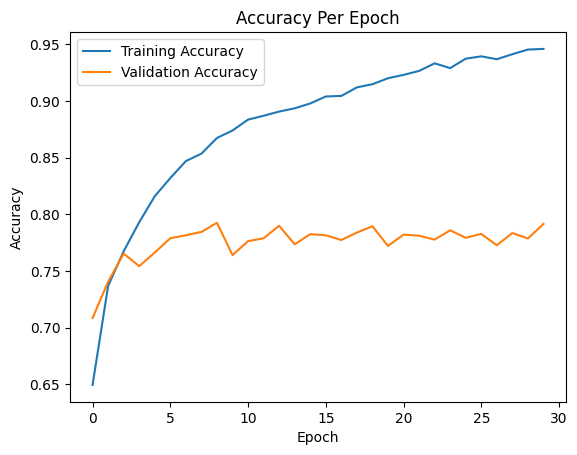

In [ ]:
# Plot the change in accuracy of the SGD optimizer and ReLU activation
import matplotlib.pyplot as plt

plt.plot(rmsprop_relu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(rmsprop_relu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

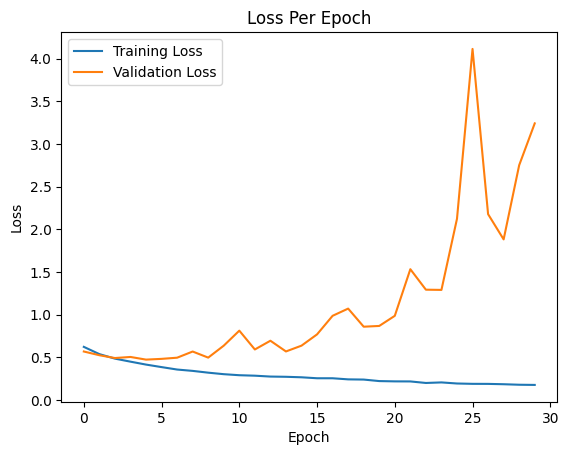

In [ ]:
# Plot the change in loss of the SGD optimizer and ReLU activation
import matplotlib.pyplot as plt

plt.plot(rmsprop_relu_model.history.history['loss'], label='Training Loss')
plt.plot(rmsprop_relu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values of the SGD optimizer and ReLU activation
train_loss = rmsprop_relu_model.history.history['loss'][-1]
val_loss = rmsprop_relu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.17741727828979492
Final validation loss: 3.2414724826812744


Observations: 

## **Adam with LeakyReLu:**

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


In [ ]:
from tensorflow.keras.layers import LeakyReLU

# Create the model with the Adam optimizer and LeakyReLU activation
adam_leakyrelu_model = create_model(optimizer='adam', activation=LeakyReLU(alpha=0.1), kernel_size=3)

In [ ]:
# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

In [ ]:
# Train the Adam model with LeakyReLU activation
adam_leakyrelu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 72s 35ms/step - loss: 0.6396 - accuracy: 0.6259 - val_loss: 0.5628 - val_accuracy: 0.7176
Epoch 2/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.5325 - accuracy: 0.7321 - val_loss: 0.5069 - val_accuracy: 0.7468
Epoch 3/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.4643 - accuracy: 0.7786 - val_loss: 0.4930 - val_accuracy: 0.7558
Epoch 4/30
2000/2000 [==============================] - 69s 35ms/step - loss: 0.4050 - accuracy: 0.8127 - val_loss: 0.4963 - val_accuracy: 0.7662
Epoch 5/30
2000/2000 [==============================] - 68s 34ms/step - loss: 0.3473 - accuracy: 0.8448 - val_loss: 0.4970 - val_accuracy: 0.7706
Epoch 6/30
2000/2000 [==============================] - 69s 34ms/step - loss: 0.2882 - accuracy: 0.8738 - val_loss: 0.4966 - val_accuracy: 0.7872
Epoch 7/30
2000/2000 [==============================] - 69s 35ms/step - loss: 0.2301 - accuracy: 0.9006 - val_loss: 0.5752 -

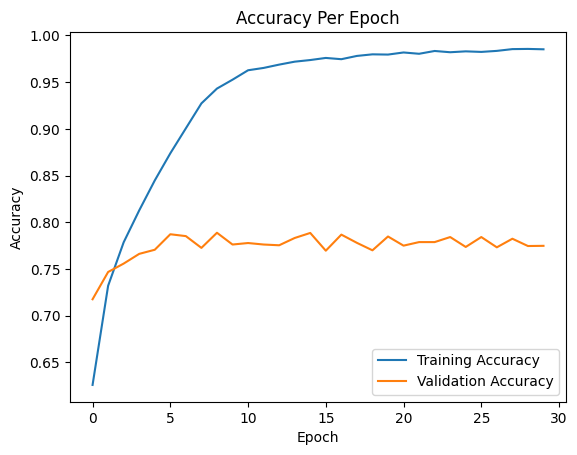

In [ ]:
# Plot the change in accuracy of the Adam model with LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(adam_leakyrelu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(adam_leakyrelu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

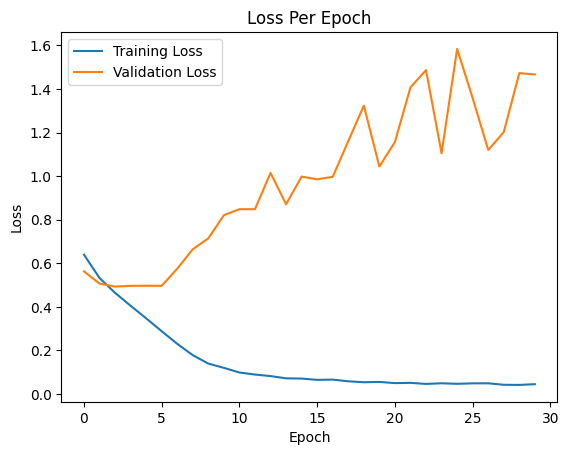

In [ ]:
# Plot the change in loss of the Adam model with LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(adam_leakyrelu_model.history.history['loss'], label='Training Loss')
plt.plot(adam_leakyrelu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values of the Adam model with LeakyReLU activation
train_loss = adam_leakyrelu_model.history.history['loss'][-1]
val_loss = adam_leakyrelu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.04491736739873886
Final validation loss: 1.4667340517044067


Observations: 

## **SGD with LeakyReLu:**

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LeakyReLU

sgd = SGD(learning_rate=0.01, momentum=0.9)

# Create the model with the SGD optimizer and LeakyReLU activation
sgd_leakyrelu_model = create_model(optimizer=sgd, activation=LeakyReLU(alpha=0.1), kernel_size=3)

In [ ]:
# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

In [ ]:
# Train the SGD model with LeakyReLU activation
sgd_leakyrelu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 80s 40ms/step - loss: 0.6566 - accuracy: 0.5972 - val_loss: 0.6002 - val_accuracy: 0.6744
Epoch 2/30
2000/2000 [==============================] - 69s 35ms/step - loss: 0.5680 - accuracy: 0.7052 - val_loss: 0.5493 - val_accuracy: 0.7314
Epoch 3/30
2000/2000 [==============================] - 69s 34ms/step - loss: 0.5118 - accuracy: 0.7508 - val_loss: 0.5428 - val_accuracy: 0.7362
Epoch 4/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.4648 - accuracy: 0.7809 - val_loss: 0.5025 - val_accuracy: 0.7628
Epoch 5/30
2000/2000 [==============================] - 69s 35ms/step - loss: 0.4270 - accuracy: 0.8002 - val_loss: 0.4969 - val_accuracy: 0.7626
Epoch 6/30
2000/2000 [==============================] - 69s 34ms/step - loss: 0.3911 - accuracy: 0.8191 - val_loss: 0.4835 - val_accuracy: 0.7690
Epoch 7/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.3542 - accuracy: 0.8435 - val_loss: 0.4771 -

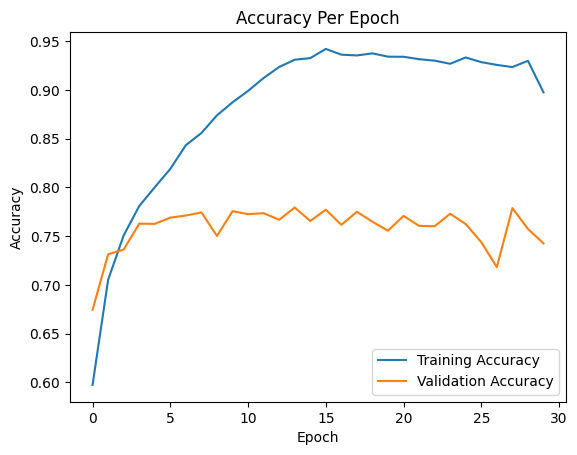

In [ ]:
# Plot the change in accuracy of the SGD optimizer and LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(sgd_leakyrelu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(sgd_leakyrelu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

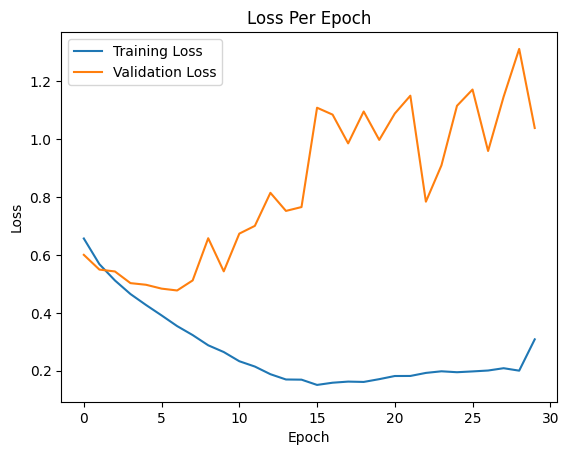

In [ ]:
# Plot the change in loss of the SGD optimizer and LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(sgd_leakyrelu_model.history.history['loss'], label='Training Loss')
plt.plot(sgd_leakyrelu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values of the sgd model with LeakyReLU activation
train_loss = sgd_leakyrelu_model.history.history['loss'][-1]
val_loss = sgd_leakyrelu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.30844083428382874
Final validation loss: 1.0379974842071533


Observations: 

## **RMSprop with LeakyReLu:**

In [ ]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import LeakyReLU

rmsprop = RMSprop(learning_rate=0.001)

# Create the model with the RMSprop optimizer and LeakyReLU activation
rmsprop_leakyrelu_model = create_model(optimizer=rmsprop, activation=LeakyReLU(alpha=0.1), kernel_size=3)

In [ ]:
# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

In [ ]:
# Train the RMSprop model with LeakyReLU activation
rmsprop_leakyrelu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 72s 36ms/step - loss: 0.6236 - accuracy: 0.6488 - val_loss: 0.6117 - val_accuracy: 0.6874
Epoch 2/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.5318 - accuracy: 0.7363 - val_loss: 0.5288 - val_accuracy: 0.7460
Epoch 3/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.4830 - accuracy: 0.7684 - val_loss: 0.5158 - val_accuracy: 0.7484
Epoch 4/30
2000/2000 [==============================] - 70s 35ms/step - loss: 0.4399 - accuracy: 0.7985 - val_loss: 0.4844 - val_accuracy: 0.7686
Epoch 5/30
2000/2000 [==============================] - 69s 35ms/step - loss: 0.4003 - accuracy: 0.8231 - val_loss: 0.5027 - val_accuracy: 0.7714
Epoch 6/30
2000/2000 [==============================] - 74s 37ms/step - loss: 0.3619 - accuracy: 0.8458 - val_loss: 0.5456 - val_accuracy: 0.7654
Epoch 7/30
2000/2000 [==============================] - 69s 35ms/step - loss: 0.3197 - accuracy: 0.8637 - val_loss: 0.4860 -

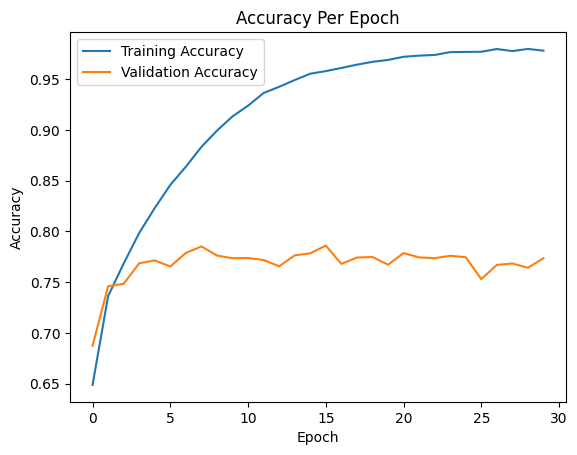

In [ ]:
# Plot the change in accuracy of the RMSprop model with LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(rmsprop_leakyrelu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(rmsprop_leakyrelu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

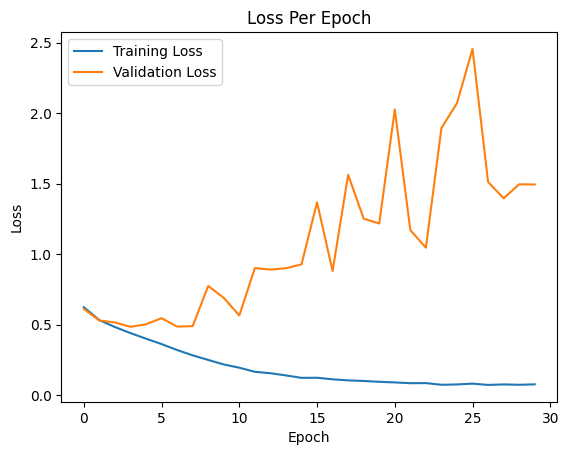

In [ ]:
# Plot the change in loss of the RMSprop model with LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(rmsprop_leakyrelu_model.history.history['loss'], label='Training Loss')
plt.plot(rmsprop_leakyrelu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Print out the final loss values of the RMSprop model with LeakyReLU activation
train_loss = rmsprop_leakyrelu_model.history.history['loss'][-1]
val_loss = rmsprop_leakyrelu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.07636148482561111
Final validation loss: 1.4939481019973755


Observations: 

# **Comparing Kernel Size:**

In [15]:
#Load the dataset: 
X, y = load_dataset(path)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Print the number of samples in each of the variables to ensure proper split
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 20000
Number of samples in X_test: 5000
Number of samples in y_train: 20000
Number of samples in y_test: 5000


Because the Adam with LeakyReLU performed the best, I only compared the kernel size of with this one. Changing the kernel size to 5.

In [16]:
from tensorflow.keras.layers import LeakyReLU

# Create the model with the Adam optimizer and LeakyReLU activation
adam_leakyrelu_model = create_model(optimizer='adam', activation=LeakyReLU(alpha=0.1), kernel_size=5)

In [17]:
# Create the data generator
datagen = create_datagen()

# Fit the generator on the training data
datagen.fit(X_train)

In [18]:
# Train the Adam model with LeakyReLU activation
adam_leakyrelu_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
2000/2000 [==============================] - 167s 82ms/step - loss: 0.6948 - accuracy: 0.5214 - val_loss: 0.6874 - val_accuracy: 0.6038
Epoch 2/30
2000/2000 [==============================] - 159s 79ms/step - loss: 0.6762 - accuracy: 0.5826 - val_loss: 0.6646 - val_accuracy: 0.6110
Epoch 3/30
2000/2000 [==============================] - 156s 78ms/step - loss: 0.6634 - accuracy: 0.6156 - val_loss: 0.6355 - val_accuracy: 0.6534
Epoch 4/30
2000/2000 [==============================] - 159s 79ms/step - loss: 0.6135 - accuracy: 0.6718 - val_loss: 0.5984 - val_accuracy: 0.6738
Epoch 5/30
2000/2000 [==============================] - 158s 79ms/step - loss: 0.5640 - accuracy: 0.7125 - val_loss: 0.5730 - val_accuracy: 0.7060
Epoch 6/30
2000/2000 [==============================] - 158s 79ms/step - loss: 0.5240 - accuracy: 0.7410 - val_loss: 0.5358 - val_accuracy: 0.7366
Epoch 7/30
2000/2000 [==============================] - 160s 80ms/step - loss: 0.4904 - accuracy: 0.7620 - val_loss: 0

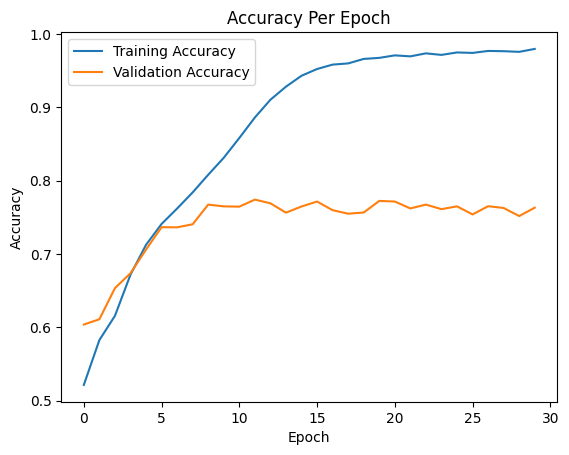

In [19]:
# Plot the change in accuracy of the Adam model with LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(adam_leakyrelu_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(adam_leakyrelu_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

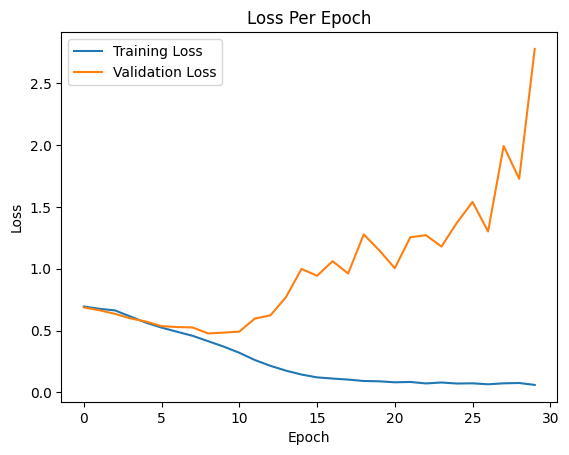

In [20]:
# Plot the change in loss of the Adam model with LeakyReLU activation
import matplotlib.pyplot as plt

plt.plot(adam_leakyrelu_model.history.history['loss'], label='Training Loss')
plt.plot(adam_leakyrelu_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Print out the final loss values of the Adam model with LeakyReLU activation
train_loss = adam_leakyrelu_model.history.history['loss'][-1]
val_loss = adam_leakyrelu_model.history.history['val_loss'][-1]
print('Final training loss:', train_loss)
print('Final validation loss:', val_loss)

Final training loss: 0.06049603968858719
Final validation loss: 2.7780423164367676
